# 自定义坐标轴刻度

虽然 `Matplotlib` 默认的坐标轴定位器（`locator`）与格式生成器（`formatter`）可以满足大部分需求，但是并非对每一幅图都合适。  
本节将通过一些示例演示如何将坐标轴刻度调整为你需要的位置与格式。

在介绍示例之前，我们最好先对 `Matplotlib` 图形的对象层级有更深入的理解。  
`Matplotlib` 的目标是用 `Python` 对象表现任意图形元素。  
例如，想想前面介绍的 `figure` 对象，它其实就是一个盛放图形元素的包围盒（`bounding box`）。  
可以将每个 `Matplotlib` 对象都看成是子对象（`subobject`）的容器，  
例如每个 `figure` 都会包含一个或多个 `axes` 对象，每个 `axes` 对象又会包含其他表示图形内容的对象。  
坐标轴刻度线也不例外。每个 `axes` 都有 `xaxis` 和 `yaxis` 属性，每个属性同样包含构成坐标轴的线条、刻度和标签的全部属性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plt.style.use('classic')

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## 1. 主要刻度与次要刻度

每一个坐标轴都有主要刻度线与次要刻度线。顾名思义，主要刻度往往更大或更显著，而次要刻度往往更小。  
虽然一般情况下 `Matplotlib` 不会使用次要刻度，但是你会在对数图中看到它们。

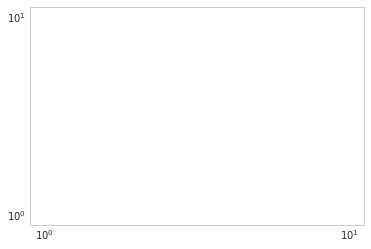

In [3]:
ax = plt.axes(xscale='log', yscale='log')  # 可能是matplotlib版本的问题，这里演示并没有出现次要刻度
ax.grid()

In [4]:
# 可以通过设置每个坐标轴的 formatter 与 locator 对象，自定义这些刻度属性（包括刻度线的位置和标签）。来检查一下图形 x 轴的属性：
print(ax.xaxis.get_major_locator())
print(ax.xaxis.get_minor_locator())

In [5]:
print(ax.xaxis.get_major_formatter())
print(ax.xaxis.get_minor_formatter())

## 2. 隐藏刻度与标签

最常用的刻度 / 标签格式化操作可能就是隐藏刻度与标签了，可以通过 `plt.NullLocator()` 与 `plt.NullFormatter()` 实现。

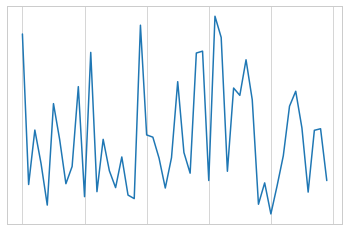

In [6]:
ax = plt.axes()
ax.plot(np.random.rand(50))

ax.yaxis.set_major_locator(plt.NullLocator())      # 移除了 y 轴的刻度（标签也一并被移除）
ax.xaxis.set_major_formatter(plt.NullFormatter())  # 移除了 x 轴的标签（但是保留了刻度线 / 网格线）

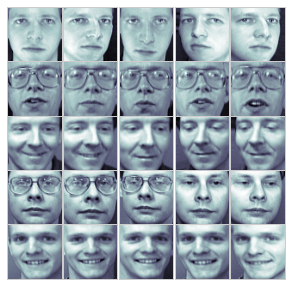

In [7]:
# 在许多场景中都不需要刻度线，比如当你想要显示一组图形时
fig, ax = plt.subplots(5, 5, figsize=(5, 5))
fig.subplots_adjust(hspace=0, wspace=0)

# 从scikit-learn获取一些人脸照片数据
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces().images              # 数据本地保存在 ../data/sklearn_olivettifaces.mat

for i in range(5):
    for j in range(5):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(faces[10 * i + j], cmap="bone")

## 3. 增减刻度数量

默认刻度标签有一个问题，就是显示较小图形时，通常刻度显得十分拥挤。

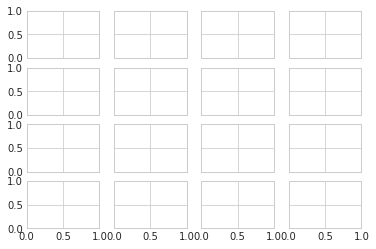

In [8]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True)

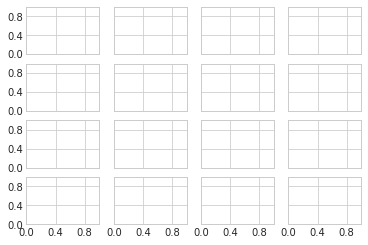

In [9]:
# 为每个坐标轴设置主要刻度定位器
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))  # 通过 plt.MaxNLocator() 可以设置最多需要显示多少刻度。根据设置的最多刻度数量，Matplotlib 会自动为刻度安排恰当的位置
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
fig

## 4. 花哨的刻度格式

(0.0, 9.42477796076938)

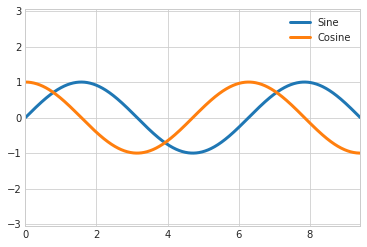

In [10]:
# 画正弦曲线和余弦曲线
fig, ax = plt.subplots()
x = np.linspace(0, 3 * np.pi, 1000)
ax.plot(x, np.sin(x), lw=3, label='Sine')
ax.plot(x, np.cos(x), lw=3, label='Cosine')

# 设置网格、图例和坐标轴上下限
ax.grid(True)
ax.legend(frameon=False)
ax.axis('equal')
ax.set_xlim(0, 3 * np.pi)

我们可能想稍稍改变一下这幅图。首先，如果将刻度与网格线画在 `π` 的倍数上，图形会更加自然。  
可以通过设置一个 `MultipleLocator` 来实现，它可以将刻度放在你提供的数值的倍数上。  
为了更好地测量，在 `π/4` 的倍数上添加主要刻度和次要刻度：

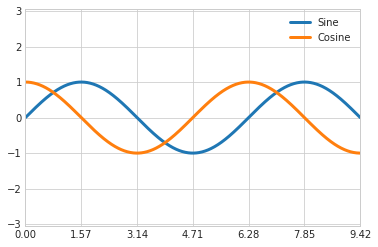

In [11]:
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 4))
fig

然而，这些刻度标签看起来有点奇怪：虽然我们知道它们是 `π` 的倍数，但是用小数表示圆周率不太直观。  
因此，我们可以用刻度格式生成器来修改。由于没有内置的格式生成器可以直接解决问题，因此需要用 `plt.FuncFormatter` 来实现，用一个自定义的函数设置不同刻度标签的显示：

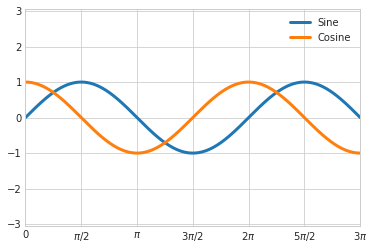

In [12]:
def format_func(value, tick_number):
    # 找到 π/2 的倍数刻度
    # 这里我们用了 Matplotlib 支持 LaTeX 的功能，在数学表达式两侧加上美元符号（$），这样可以非常方便地显示数学符号和数学公式
    # 在这里，"$\pi$" 就表示圆周率符合π
    N = int(np.round(2 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))  # 当你准备展示或打印图形时，plt.FuncFormatter() 可以为自定义图形刻度提供十分灵活的功能
fig

## 5. 格式生成器与定位器小结

| 定位器类 | 描述 |
| -- | -- |
| NullLocator | 无刻度 |
| FixedLocator | 刻度位置固定 |
| IndexLocator | 用索引作为定位器（如 x = range(len(y))） |
| LinearLocator | 从 min 到 max 均匀分布刻度 |
| LogLocator | 从 min 到 max 按对数分布刻度 |
| MultipleLocator | 刻度和范围都是基数（base）的倍数 |
| MaxNLocator | 为最大刻度找到最优位置 |
| AutoLocator | （默认）以 MaxNLocator 进行简单配置 |
| AutoMinorLocator | 次要刻度的定位器 |

| 格式生成器类 | 描述 |
| -- | -- |
| NullFormatter | 刻度上无标签 |
| IndexFormatter | 将一组标签设置为字符串 |
| FixedFormatter | 手动为刻度设置标签 |
| FuncFormatter | 用自定义函数设置标签 |
| FormatStrFormatter | 为每个刻度值设置字符串格式 |
| ScalarFormatter | （默认）为标量值设置标签 |
| LogFormatter | 对数坐标轴的默认格式生成器 |